# Aufgabe 2
## Datenanalyse

In [92]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

from scipy.stats import shapiro

import folium
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [2]:
DATA_DIR = Path("..", "data")
RAW, OUT = DATA_DIR / "raw", DATA_DIR / "processed"

## Load preprocessed Datasets

In [3]:
df_nasdaq_daily_pp = pd.read_csv(OUT / "df_nasdaq_daily.csv", keep_default_na=False)
df_nasdaq_daily_pp["date"] = pd.to_datetime(df_nasdaq_daily_pp["date"])

df_nasdaq_weekly_pp = pd.read_csv(OUT / "df_nasdaq_weekly.csv", keep_default_na=False)

df_crypto_daily_pp = pd.read_csv(OUT / "df_crypto_daily.csv", keep_default_na=False)
df_crypto_daily_pp["date"] = pd.to_datetime(df_crypto_daily_pp["date"])

df_crypto_weekly_pp = pd.read_csv(OUT / "df_crypto_weekly.csv", keep_default_na=False)

df_nasdaq_meta_pp = pd.read_csv(OUT / "df_nasdaq_meta.csv", keep_default_na=False)

## NASDAQ Stocks: Industry & Lifetime


3342 Stocks have been listed in the NASDAQ Index.
Average lifetime of a company in NASDAQ: 11.33 years


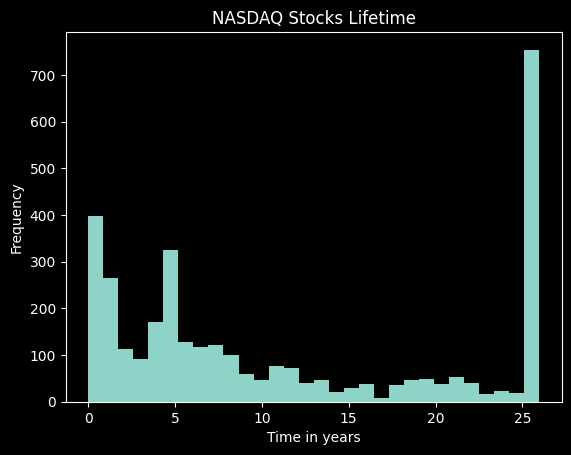

In [4]:
print(f"{len(df_nasdaq_daily_pp["ticker"].unique())} Stocks have been listed in the NASDAQ Index.")

df_nasdaq_first_last = (df_nasdaq_daily_pp.groupby("ticker")["date"]
                        .agg(firstdate="min", lastdate="max")
                        .reset_index()
                        )

df_nasdaq_first_last["lifetime"] = (df_nasdaq_first_last["lastdate"] - df_nasdaq_first_last["firstdate"]).dt.days / 365
print(f"Average lifetime of a company in NASDAQ: {df_nasdaq_first_last["lifetime"].mean():.2f} years")

df_nasdaq_first_last["lifetime"].plot.hist(
    title="NASDAQ Stocks Lifetime",
    xlabel="Time in years",
    bins=30,
)
plt.show()


### Industry Changes
We compare branches every fifth year.<br>
Health care has grown extremely. Companies in the sector Consumer Discretionary, Technology and Finance have also noticeably

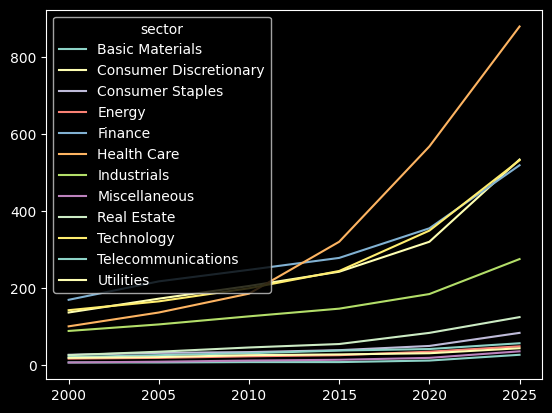

,2000,2005,2010,2015,2020,2025
sector,,,,,,
Basic Materials,6,6,7,7,11,26
Consumer Discretionary,136,172,205,242,320,534
Consumer Staples,26,31,33,38,49,83
Energy,16,18,22,25,34,48
Finance,169,217,247,278,355,519
Health Care,100,136,185,320,568,880
Industrials,88,105,126,146,184,275
Miscellaneous,6,8,11,13,18,35
Real Estate,25,34,45,54,83,124


In [58]:
nasdaq_first_date = df_nasdaq_daily_pp["date"].min()
nasdaq_last_date = df_nasdaq_daily_pp["date"].max()

INDUSTRY_COL = "sector"   # "sector" or "industry" - Select the column to analyze. Sector has less unique values - Industry is more specific

def getIndustry(year: int) -> pd.Series:
    """
    Counts the active companies of each industry in the specific year
    :return: industry -> amount - Series
    """
    df_active = df_nasdaq_daily_pp[df_nasdaq_daily_pp["date"].dt.year == year]
    s_industry = df_nasdaq_meta_pp.set_index("ticker")
    s_industry = s_industry.reindex(df_active["ticker"].unique())[INDUSTRY_COL]
    return s_industry[s_industry != ""].value_counts()


selected_years = pd.date_range(str(nasdaq_first_date.year), str(nasdaq_last_date.year), freq="5YS").year

df_nasdaq_industry = pd.DataFrame({
    year: getIndustry(year)
    for year in selected_years
})

if INDUSTRY_COL == "sector":
    df_nasdaq_industry.T.plot.line()
    plt.show()

df_nasdaq_industry

## Lifetime
The amount of active stocks each is will be determined. The result is plotted.<br>
The assumption, the NASDAQ Composite has been growing, is wrong.<br>
Our Internet researches have shown that there have been more stocks earlier that aren't mentioned in this dataset.

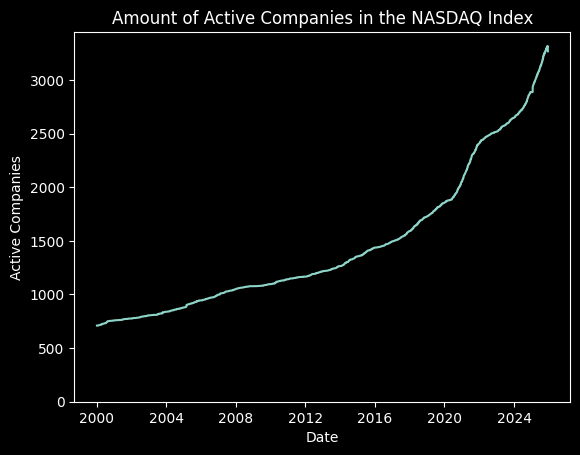

In [21]:
dates_between = pd.date_range(nasdaq_first_date, nasdaq_last_date, freq='D')

# count active tickers per day
counts = pd.Series(dates_between).apply(lambda d: ((df_nasdaq_first_last["firstdate"] <= d) & (df_nasdaq_first_last["lastdate"] >= d)).sum())

plt.plot(dates_between, counts)
plt.xlabel('Date')
plt.ylabel('Active Companies')
plt.title("Amount of Active Companies in the NASDAQ Index")
plt.ylim(0)
plt.show()

## NASDAQ Winning Stocks per Year

In [59]:
df_nasdaq_yearly = df_nasdaq_daily_pp.copy()

df_nasdaq_yearly["year"] = df_nasdaq_yearly["date"].dt.year

df_nasdaq_yearly = (
    df_nasdaq_yearly.groupby(["ticker", "year"])["close"]
      .agg(start="first", end="last")
      .reset_index()
)

df_nasdaq_yearly["win"] = df_nasdaq_yearly["end"] > df_nasdaq_yearly["start"]
df_nasdaq_yearly["difference"] = df_nasdaq_yearly["end"] - df_nasdaq_yearly["start"]

s_wins_per_year = df_nasdaq_yearly.groupby("year")["win"].sum() / df_nasdaq_yearly.groupby("year")["ticker"].count()
s_difference_per_year = df_nasdaq_yearly.groupby("year")["difference"].sum() / df_nasdaq_yearly.groupby("year")["ticker"].count()

df_nasdaq_win = pd.DataFrame({"Winning Percentage": s_wins_per_year * 100, "Avg Difference": s_difference_per_year})

bestyear = s_wins_per_year.idxmax()
print("Best Year (most companies won):", bestyear)

df_nasdaq_win

Best Year (most companies won): 2003


,Winning Percentage,Avg Difference
year,,
2000,37.730871,-3.840361e+07
2001,62.451613,-9.600858e+06
2002,40.818859,-1.509305e+06
2003,90.464839,4.208639e+05
2004,64.163823,-4.135585e+05
2005,39.300847,-7.900145e+03
2006,66.232465,-1.237195e+05
2007,39.295909,5.295232e+03
2008,13.834726,-1.121025e+07


## Crypto Winning Stocks per Year

In [60]:
df_crypto_yearly = df_crypto_daily_pp.copy()

df_crypto_yearly["year"] = df_crypto_yearly["date"].dt.year

df_crypto_yearly = (
    df_crypto_yearly.groupby(["ticker", "year"])["close"]
      .agg(start="first", end="last")
      .reset_index()
)

df_crypto_yearly["win"] = df_crypto_yearly["end"] > df_crypto_yearly["start"]
df_crypto_yearly["difference"] = df_crypto_yearly["end"] - df_crypto_yearly["start"]

s_crypto_wins_per_year = df_crypto_yearly.groupby("year")["win"].sum() / df_crypto_yearly.groupby("year")["ticker"].count()
s_crypto_difference_per_year = df_crypto_yearly.groupby("year")["difference"].sum() / df_crypto_yearly.groupby("year")["ticker"].count()

df_crypto_win = pd.DataFrame({"Winning Percentage": s_crypto_wins_per_year * 100, "Avg Difference": s_crypto_difference_per_year})

df_crypto_win

,Winning Percentage,Avg Difference
year,,
2010,100.000000,0.250490
2011,100.000000,4.420000
2012,100.000000,8.240000
2013,100.000000,406.595000
2014,33.333333,-172.936667
2015,50.000000,14.378754
2016,70.000000,-439.323666
2017,100.000000,710.814634
2018,11.111111,-408.081641


It's clear that the average return of cryptocurrencies changes dramatically. The effects of the 2008 global financial crisis and the "Corona years" are clearly visible in the NASDAQ, where the average annual price change falls sharply into negative territory.

## Statistical Distribution of Closing Prices

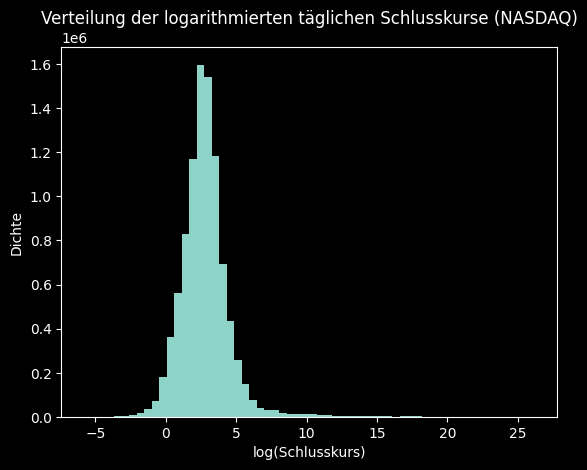

Shapiro-Wilk Statistik: 0.8978
p-Wert: 1.4224e-49


In [8]:
df_distribution = df_nasdaq_daily_pp.copy()

df_distribution["log_close"] = np.log(df_distribution["close"])

plt.hist(df_distribution["log_close"], bins=60)
plt.xlabel("log(Schlusskurs)")
plt.ylabel("Dichte")
plt.title("Verteilung der logarithmierten täglichen Schlusskurse (NASDAQ)")
plt.show()

# Achtung: Shapiro ist für sehr große n problematisch
sample = df_distribution["log_close"].sample(5000, random_state=42)

stat, p_value = shapiro(sample)

print(f"Shapiro-Wilk Statistic: {stat:.4f}")
print(f"p-Wert: {p_value:.4e}")

## Correlation Analysis
Specific stocks are compared to each other over the maximum timespan<br>
Here we can see strong correlations between every stock.<br>
All values are between 0.72 and 0.95.<br>
But this is not surprising. Because good phases and bad phases have affects on almost the whole economy.<br>
Interesting is that the cryptocurrencies are also correlating.

In [68]:
# NAME = <Ticker>, <is Crypto>
BITCOIN = "BTC", True
ETHEREUM = "ETH", True
NVIDIA = "NVDA", False
MICROSOFT = "MSFT", False
AMAZON = "AMZN", False
TESLA = "TSLA", False

stocks = [BITCOIN, ETHEREUM, NVIDIA, MICROSOFT, AMAZON, TESLA]
stock_serieses = []

for s in stocks:
    if s[1]:
        df = df_crypto_daily_pp
    else:
        df = df_nasdaq_daily_pp

    ser = df[df["ticker"] == s[0]][["date", "close"]].set_index("date")["close"]
    ser.name = s[0]
    stock_serieses.append(ser)


df_compare = pd.concat(stock_serieses, axis=1)
df_compare.corr()


,BTC,ETH,NVDA,MSFT,AMZN,TSLA
BTC,1.000000,0.871139,0.924132,0.920636,0.876006,0.876125
ETH,0.871139,1.000000,0.727424,0.885953,0.830305,0.879838
NVDA,0.924132,0.727424,1.000000,0.857114,0.765961,0.744858
MSFT,0.920636,0.885953,0.857114,1.000000,0.958316,0.920782
AMZN,0.876006,0.830305,0.765961,0.958316,1.000000,0.885355
TSLA,0.876125,0.879838,0.744858,0.920782,0.885355,1.000000


## Stock Returns
Every month, on the first day, €100 is invested in the respective stock.

In [11]:
START_DATE = pd.to_datetime("01.01.2020")
INVEST = 100    # in Euros

df_nasdaq_monthly = df_nasdaq_daily_pp.copy()
df_nasdaq_monthly = df_nasdaq_monthly[df_nasdaq_monthly["date"] >= START_DATE]
df_nasdaq_monthly["month"] = df_nasdaq_monthly["date"].dt.to_period("M")
df_nasdaq_monthly = (df_nasdaq_monthly
                     .groupby(["ticker", "month"])["close"]
                     .first()
                     .reset_index(["month"]))

df_nasdaq_monthly["count"] = INVEST / df_nasdaq_monthly["close"]
print(df_nasdaq_monthly.head())

print("-------------------------------")

s_nasdaq_last = df_nasdaq_daily_pp.groupby(["ticker"])["close"].last()
s_nasdaq_last.name = "Last Value"
s_nasdaq_count = df_nasdaq_monthly.groupby(["ticker"])["count"].sum()
s_nasdaq_count.name = "Count"

df_nasdaq_rendite = pd.concat([s_nasdaq_last, s_nasdaq_count], axis=1)
df_nasdaq_rendite["Rendite"] = s_nasdaq_last * s_nasdaq_count



df_highest_rendite = df_nasdaq_rendite.nlargest(2, "Rendite")
print(f"Höchste Rendite: {df_highest_rendite.iloc[0].name} mit {df_highest_rendite.iloc[0]["Rendite"]:.2f} €")
print(f"Zweit Höchste Rendite: {df_highest_rendite.iloc[1].name} mit {df_highest_rendite.iloc[1]["Rendite"]:.2f} €")

df_nasdaq_rendite

          month  close      count
ticker                           
AACB    2025-04   9.88  10.121457
AACB    2025-05   9.98  10.020040
AACB    2025-06  10.09   9.910803
AACB    2025-07  10.10   9.900990
AACB    2025-08  10.12   9.881423
-------------------------------
Höchste Rendite: SMX mit 1061581.93 €
Zweit Höchste Rendite: GSAT mit 537741.14 €


,Last Value,Count,Rendite
ticker,,,
AACB,10.3000,89.047121,917.185345
AACG,0.9419,5954.932489,5608.950911
AAL,14.9600,503.539396,7532.949359
AAME,2.4800,3175.191346,7874.474537
AAOI,32.0600,1227.510611,39353.990203
...,...,...,...
ZURA,4.0200,1223.166586,4917.129677
ZVRA,8.3300,1129.323758,9407.266906
ZYBT,2.0100,279.706377,562.209818


In [12]:
START_DATE = pd.to_datetime("01.01.2020")
INVEST = 100    # in Euros

df_crypto_monthly = df_crypto_daily_pp.copy()
df_crypto_monthly = df_crypto_monthly[df_crypto_monthly["date"] >= START_DATE]
df_crypto_monthly["month"] = df_crypto_monthly["date"].dt.to_period("M")
df_crypto_monthly = (df_crypto_monthly
                     .groupby(["ticker", "month"])["close"]
                     .first()
                     .reset_index(["month"]))

df_crypto_monthly["count"] = INVEST / df_crypto_monthly["close"]
print(df_crypto_monthly.head())

print("-------------------------------")

s_crypto_last = df_crypto_daily_pp.groupby(["ticker"])["close"].last()
s_crypto_last.name = "Last Value"
s_crypto_count = df_crypto_monthly.groupby(["ticker"])["count"].sum()
s_crypto_count.name = "Count"

df_crypto_rendite = pd.concat([s_crypto_last, s_crypto_count], axis=1)
df_crypto_rendite["Rendite"] = s_crypto_last * s_crypto_count

print(f"Höchste Rendite: {df_crypto_rendite["Rendite"].idxmax()} mit {df_crypto_rendite["Rendite"].max():.2f} €")

df_crypto_rendite

          month  close      count
ticker                           
1INCH   2021-01  1.200  83.333333
1INCH   2021-02  5.053  19.790224
1INCH   2021-03  4.103  24.372410
1INCH   2021-04  4.448  22.482014
1INCH   2021-05  5.521  18.112661
-------------------------------
Höchste Rendite: SOL mit 129508.52 €


,Last Value,Count,Rendite
ticker,,,
1INCH,0.170651,1.387854e+04,2368.387315
AAVE,192.117600,5.565610e+01,10692.515681
ADA,0.410623,3.033350e+04,12455.633049
ALGO,0.123037,2.984311e+04,3671.806745
AMP,0.002057,1.292610e+06,2658.898438
...,...,...,...
XRP,2.011100,1.454963e+04,29260.766073
XTZ,0.550165,6.056385e+03,3332.011312
YFI,3559.758000,8.704628e-01,3098.637049


Das lukrativste Aktien-Krypto-Triplet ist somit: ... und Solana     #TODO

### (Interactive) Plot

In [89]:
def get_rendite(ticker:str, is_crypto:bool, start_date:pd.Timestamp, end_date:pd.Timestamp, invest:int) -> pd.DataFrame:
    """
    :param ticker: Ticker
    :param is_crypto: if the ticker is a cryptocurrency
    :param start_date: from
    :param end_date: to
    :param invest: monthly invested amount
    :return: DataFrame with index month and columns close, count, total_count, value, total_invest
    """

    if is_crypto:
        df_rendite = df_crypto_daily_pp.copy()
    else:
        df_rendite = df_nasdaq_daily_pp.copy()

    if ticker not in df_rendite["ticker"].values:
        raise RuntimeError("Invalid Ticker. Check ticker and IS_CRYPTO")

    df_rendite = df_rendite[(df_rendite["ticker"] == ticker) & (df_rendite["date"].between(start_date, end_date))]
    df_rendite = df_rendite.drop(["ticker", "open"], axis=1)
    df_rendite["month"] = df_rendite["date"].dt.to_period("M")
    df_rendite = df_rendite.groupby(["month"]).first()
    df_rendite = df_rendite.drop("date", axis=1)

    df_rendite["count"] = invest / df_rendite["close"]
    df_rendite["total_count"] = df_rendite["count"].cumsum()
    df_rendite["value"] = df_rendite["total_count"] * df_rendite["close"]
    df_rendite["total_invest"] = np.arange(1, len(df_rendite) + 1) * 100

    return df_rendite

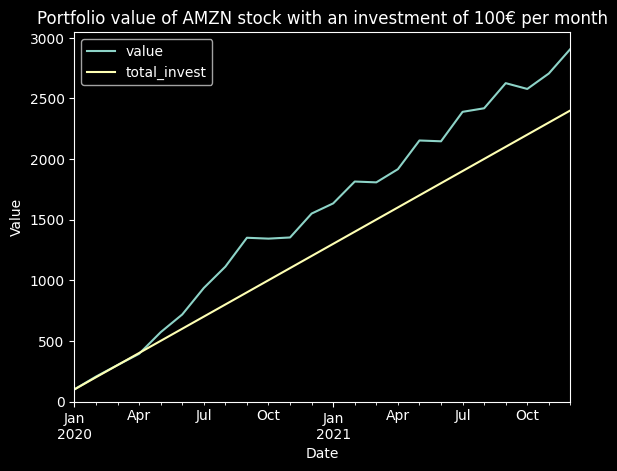

In [91]:
# MatPlotLib

TICKER = "AMZN"
IS_CRYPPTO = False
START_DATE = pd.to_datetime("1.1.2020")
END_DATE = pd.to_datetime("1.1.2022")
INVEST = 100    # in Euros

df_rendite = get_rendite(TICKER, IS_CRYPPTO, START_DATE, END_DATE, INVEST)

p = df_rendite[["value", "total_invest"]].plot.line(
    title=f"Portfolio value of {TICKER} stock with an investment of {INVEST}€ per month",
    xlabel="Date",
    ylabel="Value",
    ylim=(0, None)
)
plt.show()


In [104]:
INVEST = 100    # in Euros
import plotly.graph_objects as go
from ipywidgets import widgets, VBox, Output
import plotly.io as pio

# --- UI Widgets ---
ticker_widget = widgets.Text(value="AMZN", description="Ticker:")
start_widget = widgets.DatePicker(value=pd.to_datetime("2020-01-01"), description="Start Date:")
end_widget = widgets.DatePicker(value=pd.to_datetime("2022-01-01"), description="End Date:")
crypto_widget = widgets.Checkbox(value=False, description="Is Crypto?")
update_button = widgets.Button(description="Update Plot")
out = Output()

# --- Callback to update figure ---
def update_plot(b):
    out.clear_output(wait=True)  # clear previous figure

    if start_widget.value is None or end_widget.value is None:
        with out:
            print("Please select valid start and end dates")
        return

    # --- Use your get_rendite function ---
    df = get_rendite(
        ticker=ticker_widget.value,
        is_crypto=crypto_widget.value,
        start=start_widget.value,
        end=end_widget.value,
        initial_investment=100
    )

    # --- Check that df has required columns ---
    if "date" not in df.columns or "close" not in df.columns:
        with out:
            print("DataFrame must contain 'date' and 'close' columns")
        return

    # --- Create Plotly figure ---
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df["date"],
        y=df["close"],
        mode="lines+markers",
        name=f"{ticker_widget.value} - {'Crypto' if crypto_widget.value else 'Stock'}"
    ))

    fig.update_layout(
        title=f"{ticker_widget.value} ({start_widget.value} → {end_widget.value})",
        xaxis_title="Date",
        yaxis_title="Investment Value",
        template="plotly_white",
        hovermode="x unified"
    )

    # --- Display figure inside Output widget ---
    with out:
        pio.show(fig)

# --- Connect button ---
update_button.on_click(update_plot)

# --- Display UI ---
display(VBox([ticker_widget, start_widget, end_widget, crypto_widget, update_button, out]))

## Geo Map

In [81]:
# Filter non US States and remove empty addresses
df_meta = df_nasdaq_meta_pp.copy()[df_nasdaq_meta_pp["country"] == "United States"]
df_meta = df_meta[df_meta["address"] != ""]

Get Coordinates of each city.<br>
Because of the rate limits this took 2:44h. So I saved the result into `df_nasdaq_loc.csv` and commented the code out.

In [20]:
"""
df_loc = df_meta.copy()
df_loc["city"] = df_loc["address"].str.split(r",\s*").str[-4:-2].str.join(", ")
df_loc = df_loc[["ticker", "city"]]

geolocator = Nominatim(user_agent="nasdaq_geo_analysis")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

df_loc["geocode"] = df_loc["city"].apply(geocode)
df_loc = df_loc[df_loc["geocode"].notna()]
df_loc["latitude"] = df_loc["geocode"].apply(lambda loc: loc.latitude)
df_loc["longitude"] = df_loc["geocode"].apply(lambda loc: loc.longitude)

df_loc = df_loc.drop(["geocode", "city"], axis=1)

df_loc.to_csv(OUT / "df_nasdaq_loc.csv", index=False)
"""


<>:3: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:3: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
C:\Users\Matthias\AppData\Local\Temp\ipykernel_9696\3931135471.py:3: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
  df_loc["city"] = df_loc["address"].str.split(r",\s*").str[-4:-2].str.join(", ")


In [83]:
df_loc = pd.read_csv(OUT / "df_nasdaq_loc.csv")
df_loc = df_loc.merge(df_meta[["ticker", "address"]], on="ticker", how="left")

m = folium.Map(
    location=[39.5, -98.35],
    zoom_start=4,
    tiles="CartoDB positron"
)

for _, row in df_loc.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=4,
        popup=f"Ticker: {row['ticker']}<br>Address: {row['address']}",
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

m

     ticker   latitude   longitude  \
2116     UK  39.933374  116.448696   

                                                address        country  
2116  GUANG HUA ROAD,NO. 2, TOWER D, FLOOR 8, BEIJIN...  United States  


Some Companies have the country attribute wrongly set to the United States, so we can see them. But to filter them would take too much time.<br>
We see that the NASDAQ companies are spreaded over the US (except some States like Wyoming) but tend to be more on the east of America.<br>
There are some areas where companies are concentrated, like New York, Chicago, San Francisco (Silicon Valley), Los Angeles, Seattle and Denver.<br>